In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy.time import Time

from orbitize.results import Results
from orbitize.sampler import MCMC
from orbitize.lnlike import chi2_lnlike

In [2]:
# load the posteriors from the various orbit fits

nograv_results = Results()
nograv_results.load_results('results/with_literature_astrom/chains.hdf5')

onegrav_results = Results()
onegrav_results.load_results('results/with_literature_astromwith_first_vlti_point/chains.hdf5')

other_onegrav_results = Results()
other_onegrav_results.load_results('results/with_literature_astromwith_second_vlti_point/chains.hdf5')

twograv_results = Results()
twograv_results.load_results('results/with_literature_astromwith_first_vlti_pointwith_second_vlti_point/chains.hdf5')

onlygrav_results = Results()
onlygrav_results.load_results('results/with_first_vlti_pointwith_second_vlti_point/chains.hdf5')

fixed_ecc_results = Results()
fixed_ecc_results.load_results('results/with_literature_astromwith_first_vlti_pointwith_second_vlti_point_fixed_ecc/chains.hdf5')

lin_ecc_results = Results()
lin_ecc_results.load_results('results/with_literature_astromwith_first_vlti_pointwith_second_vlti_point_linear_ecc/chains.hdf5')

all_results = {
    nograv_results: ['literature data only', 'results/with_literature_astrom/'],
    onegrav_results:['literature + GRAVITY epoch 1' , 'results/with_literature_astromwith_first_vlti_point/'],
    other_onegrav_results: ['literature + GRAVITY epoch 2', 'results/with_literature_astromwith_second_vlti_point/'],
    twograv_results: ['all data','results/with_literature_astromwith_first_vlti_pointwith_second_vlti_point/'],
    onlygrav_results:['GRAVITY data only','results/with_first_vlti_pointwith_second_vlti_point/'],
    fixed_ecc_results:['all data, ecc. fixed to 0','results/with_literature_astromwith_first_vlti_pointwith_second_vlti_point_fixed_ecc/'],
    lin_ecc_results:['all data, decreasing ecc. prior','results/with_literature_astromwith_first_vlti_pointwith_second_vlti_point_linear_ecc/']
}

In [3]:
# make MCMC convergence plots
params = {'ecc1':'e', 'pan1':'$\\Omega$','aop1':'$\\omega$'}
for param in params.keys():

    for res in all_results:
        smas = res.post[:, res.system.param_idx[param]]

        num_walkers = 1000
        n_steps = len(smas) // num_walkers
        chn = smas.reshape((num_walkers, n_steps))

        walkers_to_plot = np.random.choice(num_walkers, size=100, replace=False)
        plt.figure()
        chop_after = 0
        for w in walkers_to_plot:
            plt.plot(chn[w, :][chop_after:], color='k', alpha=0.005)
        plt.xlabel('step number / 100')
        plt.ylabel(params[param])
        plt.title('{}'.format(all_results[res][0]))
        plt.savefig('{}{}chains.png'.format(all_results[res][1], param), dpi=250)
        plt.close()

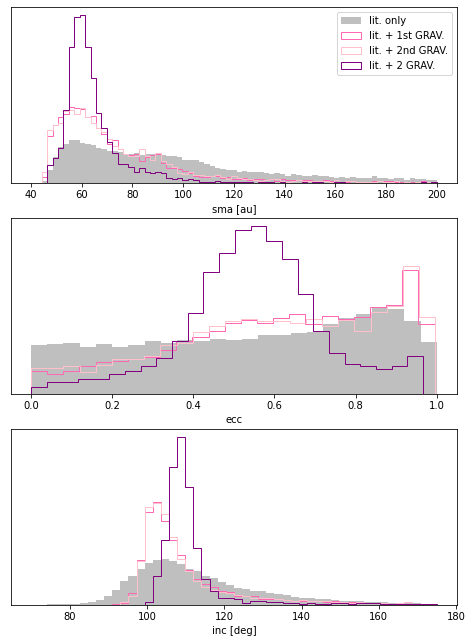

In [6]:
# plot all the sma, ecc, and inc posteriors
fig, ax = plt.subplots(3, 1, figsize=(8,11))
for a in ax:
    a.set_yticks([])

ax[0].set_xlabel('sma [au]')
ax[1].set_xlabel('ecc')
ax[2].set_xlabel('inc [deg]')

plot_dict = {
    nograv_results: {'ec': None, 'fc': 'grey', 'alpha': 0.5, 'histtype':'stepfilled'},
    onegrav_results: {'ec': 'hotpink', 'fc': 'white', 'histtype':'step'},
    other_onegrav_results: {'ec': 'pink', 'fc': 'white', 'histtype':'step'},
    twograv_results: {'ec': 'purple', 'fc': 'white',  'histtype':'step'},
    onlygrav_results: {'ec': None, 'fc': 'skyblue',  'histtype':'stepfilled', 'alpha':0.5}
}

for res, lab in zip(
    [nograv_results, onegrav_results, other_onegrav_results, twograv_results, onlygrav_results],
    ['lit. only', 'lit. + 1st GRAV.', 'lit. + 2nd GRAV.', 'lit. + 2 GRAV.', 'GRAV. only']
):
    ax[0].hist(res.post[:, res.system.param_idx['sma1']], bins=75, range=(40, 200), label=lab, **plot_dict[res], density=True)
    ax[1].hist(res.post[:, res.system.param_idx['ecc1']], bins=25, **plot_dict[res], density=True)
    ax[2].hist(np.degrees(res.post[:, res.system.param_idx['inc1']]), range=(70, 175), bins=50, **plot_dict[res], density=True)

ax[0].legend()
plt.savefig('results/plots/orbit_compare.png', dpi=250)

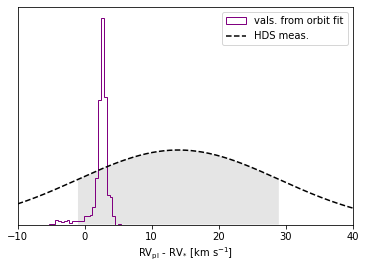

In [10]:
# plot the planetary RV vs the measurement

rv_epoch = twograv_results.data[twograv_results.data['quant_type'] == 'rv']['epoch'].value[0]

# compute the planetary RV at the measured epoch for each posterior sample
_, _, rv_out = twograv_results.system.compute_all_orbits(
    twograv_results.post.T, epochs=np.array([rv_epoch])
)

rv_predictions = rv_out[0,1,:]
plt.figure()
plt.hist(
    rv_predictions, bins=25, density=True, label='vals. from orbit fit', 
    histtype='step', color='purple'
)

# overplot the RV measurement and uncertainty
rv_meas = twograv_results.data[twograv_results.data['quant_type'] == 'rv']['quant1'].value[0]
rv_unc = twograv_results.data[twograv_results.data['quant_type'] == 'rv']['quant1_err'].value[0]

rv2plot = np.linspace(-10, 40, int(1e3))

def norm(x, mu, sig):
    return 1 / (sig * np.sqrt(2*np.pi)) * np.exp(-0.5 * ((x - mu)/sig)**2)

plt.plot(rv2plot, 10 * norm(rv2plot, rv_meas, rv_unc), label='HDS meas.', color='k', ls='--')
plt.yticks([])
plt.xlabel('RV$_{{\\rm pl}}$ - RV$_{{*}}$ [km s$^{{-1}}$]')
plt.xlim(-10,40)

onesig_rvrange = np.linspace(rv_meas - rv_unc, rv_meas + rv_unc, int(1e3))
plt.fill_between(
    onesig_rvrange, np.zeros(int(1e3)), 10 * norm(onesig_rvrange, rv_meas, rv_unc),
    color='k', alpha=0.1, ec=None
)

plt.legend()
plt.savefig('results/plots/rv_meas.png', dpi=250)

0.9266284403669721


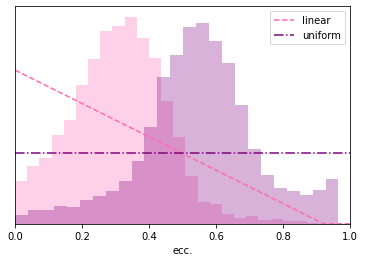

In [12]:
# compare the eccentricity posteriors using different priors

plt.figure()
colors=['hotpink', 'purple']
for i, res in enumerate([lin_ecc_results, twograv_results]):
    plt.hist(res.post[:, res.system.param_idx['ecc1']], bins=25, color=colors[i], alpha=0.3, density=True)

# overplot the prior in each case
m = -2.18
b = 2.01
xplot = np.array([0, -b/m, 1])
norm = -0.5*b**2/m
print(norm)
yplot = (m * xplot + b) / norm
yplot[-1] = 0

plt.plot(xplot, yplot, color=colors[0], ls='--', label='linear')
plt.plot(xplot, np.ones(len(xplot)), color=colors[1], ls='-.', label='uniform')
plt.xlim(0,1)
plt.legend()
plt.yticks([])
plt.xlabel('ecc.')
plt.savefig('results/plots/ecc_compare.png', dpi=250)

0.0
0.3761669812841645
-16.987904942883077
-17.00243904823773


(16.5, 17.5)

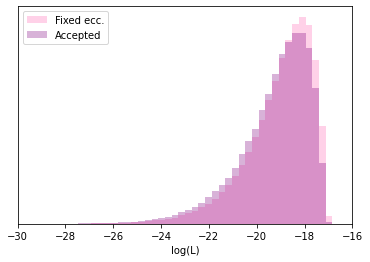

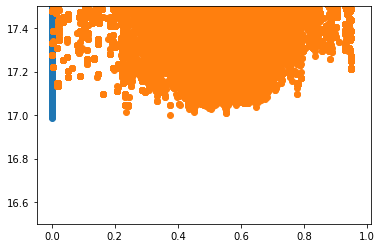

In [13]:
# plot the log-likelihoods for the fixed eccentricity posterior vs the accepted one


plt.figure()
labels = ['Fixed ecc.','Accepted']
colors = ['hotpink','purple']
for i, res in enumerate([fixed_ecc_results, twograv_results]):
    plt.hist(res.lnlike, bins=50, alpha=0.3, density=True, label=labels[i], color=colors[i], range=(-30,-16))
    print(res.post[:,1][np.argmax(res.lnlike)])
    # plt.hist(res.lnlike[res.post[:,1] > 0.4], density=True, alpha=0.5,bins=50, range=(-30,-16))
plt.yticks([])
plt.legend()
plt.xlim(-30,-16)
plt.xlabel('log(L)')
plt.savefig('results/plots/ecc_lnlike_compare.png', dpi=250)

plt.figure()
for i, res in enumerate([fixed_ecc_results, twograv_results]):
    ecc_post = res.post[:,1]
    plt.scatter(ecc_post, -1*res.lnlike)
    print(np.max(res.lnlike))
plt.ylim(16.5, 17.5)

Best lnlike for e=0.000: 17.031
Best lnlike for e=0.042: 17.017
Best lnlike for e=0.084: 17.017
Best lnlike for e=0.126: 17.054
Best lnlike for e=0.168: 17.047
Best lnlike for e=0.211: 17.072
Best lnlike for e=0.253: 17.096
Best lnlike for e=0.295: 17.120
Best lnlike for e=0.337: 17.105
Best lnlike for e=0.379: 17.157
Best lnlike for e=0.421: 17.144
Best lnlike for e=0.463: 17.220
Best lnlike for e=0.505: 17.251
Best lnlike for e=0.547: 17.323
Best lnlike for e=0.589: 17.330
Best lnlike for e=0.632: 17.368
Best lnlike for e=0.674: 17.369
Best lnlike for e=0.716: 17.460
Best lnlike for e=0.758: 17.388
Best lnlike for e=0.800: 17.515


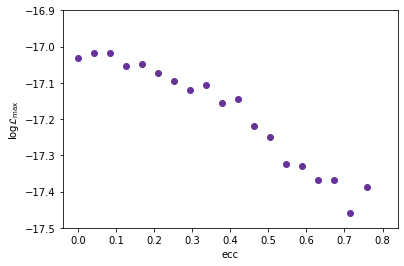

In [14]:
from scipy.optimize import minimize

plt.figure()
for e in np.linspace(0, .8, 20):
    e_sampler = MCMC(twograv_results.system)

    def neg_lnlike_func(x):
        sma, inc, aop, pan, tau = x
        if sma < 0 or inc < 0 or inc > np.pi or pan < 0 or pan > np.pi or tau < 0 or tau > 1:
            return np.inf
        return -1* e_sampler._logl([sma, e, inc, aop, pan, tau, 9.28, 1.96])

    p0 = [70, np.radians(110), np.radians(200), np.radians(160), 0.5]
    res = minimize(neg_lnlike_func, p0, method='Nelder-Mead', options={'maxiter':int(1e9), 'maxfev':int(1e10)})
    
    best_lnlike = res.fun
    print('Best lnlike for e={:.3f}: {:.3f}'.format(e, best_lnlike))

    plt.scatter([e], [-best_lnlike], color='rebeccapurple')

plt.xlabel('ecc')
plt.ylabel('log$\\mathcal{{L}}_{{\\mathrm{{max}}}}$')
plt.ylim(-17.5, -16.9)
plt.savefig('results/plots/ecc_lnlike.png', dpi=250)

In [15]:
# compute AIC & WAIC for each of the three various-eccentricity-prior fits
# ref: http://www.stat.columbia.edu/~gelman/research/published/waic_understand3.pdf
# I like the WAIC because it is v Bayesian and ya girl is v Bayesian. I'll include a pedantic rant in the paper about it.

from scipy.special import logsumexp

def calc_lnlikes(system, params):
    model, jitter = system.compute_model(params)

    # fold data/errors to match model output shape. In particualr, quant1/quant2 are interleaved
    data = np.array([system.data_table['quant1'], system.data_table['quant2']]).T

    # errors below required for lnlike function below
    errs = np.array([system.data_table['quant1_err'],
                        system.data_table['quant2_err']]).T

    corrs = system.data_table['quant12_corr']

    # grab all seppa indices
    seppa_indices = system.all_seppa

    # compute lnlike
    lnlikes = chi2_lnlike(data, errs, corrs, model, jitter, seppa_indices)

    return lnlikes

def waic(results, N=100000):
    # lots of this code stolen from pymc3 which has an excellent stats module

    # compute log-pointwise predictive density for in-sample data
    random_idx = np.random.choice(np.arange(len(results.post)), size=N)
    lnlikes = calc_lnlikes(results.system, results.post[random_idx,].T)

    # for RVs, second dimension of a data point (x1, x2) is nan
    lnlikes_i = lnlikes[:,0,:] + np.nan_to_num(lnlikes[:,1,:])

    # this is the log pointwise predictive density of each data point (i.e. the average likelihood of each posterior sample)
    lppd_i = logsumexp(lnlikes_i, axis=1, b=1/N) # eq 5 of Gelman paper linked above
    lppd = np.sum(lppd_i)
    vars_lpd = np.var(lnlikes_i, axis=1)
    # TODO: warning if vars_lpd > 0.4
    p_waic = np.sum(vars_lpd)

    # draw S samples from posterior
    # compute log-likelihood of one data point across all models, and add together, then divide by S and add across all models
    # second term computes variance of log-chi2 probability for each data point then adds over data points
    # multiply by -2 to put on same scale as AIC

    return -2 * (lppd - p_waic)
    
# intuition: want lppd to be as large as possible (i.e. want average probability of data given model to be large), so want WAIC to be as small as possible
e_uniform_waic = waic(twograv_results)
e_dec_waic = waic(lin_ecc_results)
e_fixed_waic = waic(fixed_ecc_results)
print(e_uniform_waic, e_dec_waic, e_fixed_waic)

# AIC = -2 * MLE + 2k, where k = # free params. The MLE is essentially the same for all three models (~17), so the deltaAIC is 6 ("evidence is positive but not strong")

42.37388889070533 42.066162878725066 41.55197383733148


In [21]:
# make an overleaf table of all of the fit results

def format_post(results_obj, el_label, n_decimals=1, degrees=False, dont_print_circ_toggle=False):
    quants = np.quantile(results_obj.post[:, results_obj.system.param_idx[el_label]], [.16, .50, .84])

    if dont_print_circ_toggle:
        return '--'

    if degrees:
        quants = np.degrees(quants)

    med = quants[1]
    up_lim = quants[2] - quants[1]
    lo_lim = quants[1] - quants[0]

    if up_lim == lo_lim:
        if el_label == 'ecc1':
            return '=0'

    
    if np.abs(up_lim - lo_lim) <= 1/(10*n_decimals):
        return '${:.{prec}f}\\pm{{{:.{prec}f}}}$'.format(med, up_lim, prec=n_decimals)

    return '${:.{prec}f}^{{+{:.{prec}f}}}_{{-{:.{prec}f}}}$'.format(
        med, up_lim, lo_lim, prec=n_decimals
    )



for res in all_results.keys():

    dont_print_circ_toggle = False
    if all_results[res][0] == 'all data, ecc. fixed to 0':
        dont_print_circ_toggle = True

    print('{} & {} & {} & {} & {} & {} & {} & {} & {} \\\\'.format(
        all_results[res][0],
        format_post(res, 'sma1', n_decimals=1),
        format_post(res, 'ecc1', n_decimals=2),
        format_post(res, 'inc1', n_decimals=1, degrees=True),
        format_post(res, 'aop1', n_decimals=1, degrees=True, dont_print_circ_toggle=dont_print_circ_toggle),
        format_post(res, 'pan1', n_decimals=1, degrees=True),
        format_post(res, 'tau1', n_decimals=2, dont_print_circ_toggle=dont_print_circ_toggle),
        format_post(res, 'plx', n_decimals=2),
        format_post(res, 'mtot', n_decimals=2)
    )
)
    

literature data only & $92.5^{+88.7}_{-32.0}$ & $0.58^{+0.29}_{-0.38}$ & $109.5^{+20.5}_{-11.2}$ & $181.6^{+107.6}_{-128.9}$ & $171.9^{+163.9}_{-45.3}$ & $0.36^{+0.30}_{-0.17}$ & $9.30\pm{0.03}$ & $1.96\pm{0.04}$ \\
literature + GRAVITY epoch 1 & $66.1^{+28.3}_{-12.7}$ & $0.64^{+0.26}_{-0.31}$ & $105.6^{+13.9}_{-5.0}$ & $195.6^{+74.0}_{-95.9}$ & $156.9^{+171.0}_{-8.1}$ & $0.44\pm{0.15}$ & $9.30\pm{0.03}$ & $1.96\pm{0.04}$ \\
literature + GRAVITY epoch 2 & $66.3^{+27.2}_{-13.0}$ & $0.63\pm{0.27}$ & $105.4^{+14.9}_{-4.8}$ & $194.3^{+70.5}_{-101.6}$ & $156.5^{+172.2}_{-7.6}$ & $0.43\pm{0.15}$ & $9.30\pm{0.03}$ & $1.96\pm{0.04}$ \\
all data & $61.1^{+10.4}_{-5.5}$ & $0.55\pm{0.15}$ & $109.0^{+4.4}_{-3.1}$ & $189.4^{+25.0}_{-19.0}$ & $154.9^{+5.8}_{-3.4}$ & $0.44\pm{0.08}$ & $9.30\pm{0.03}$ & $1.96\pm{0.04}$ \\
GRAVITY data only & $61.4^{+9.7}_{-5.1}$ & $0.55\pm{0.14}$ & $109.6^{+4.4}_{-2.9}$ & $190.3^{+25.8}_{-19.3}$ & $155.4^{+7.2}_{-3.6}$ & $0.44\pm{0.07}$ & $9.30\pm{0.03}$ & $1.96\pm{0.

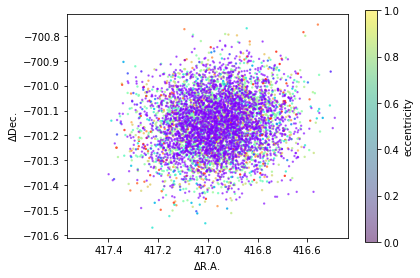

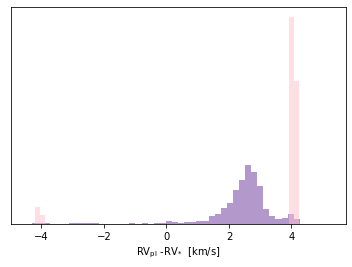

In [17]:
# run the accepted orbit fit posteriors forward in time; plot deltaRA & deltaDec by eccentricity
date = {'year':2023, 'month':5,'day':15}
epoch = Time(date, format='ymdhms')

n_to_plot = 3000
indx = np.random.choice(len(twograv_results.post), size=n_to_plot)

raoff, deoff, rv = twograv_results.system.compute_all_orbits(twograv_results.post[indx,:].T, epochs=np.array([epoch.mjd]))
raoff_pl = raoff[:,1,:][0]
deoff_pl = deoff[:,1,:][0]
rv_pl = rv[:,1,:][0] - rv[:,0,:][0]

fig, ax = plt.subplots()
eccentricities = twograv_results.post[indx,:][:,1]
plt.scatter(raoff_pl, deoff_pl, color=cm.rainbow(eccentricities), alpha=0.75, s=2)

indx = np.random.choice(len(fixed_ecc_results.post), size=n_to_plot)
raoff, deoff, rv = fixed_ecc_results.system.compute_all_orbits(fixed_ecc_results.post[indx,:].T, epochs=np.array([epoch.mjd]))
raoff_pl = raoff[:,1,:][0]
deoff_pl = deoff[:,1,:][0]
rv_pl_e0 = rv[:,1,:][0] - rv[:,0,:][0]

eccentricities = np.zeros(n_to_plot)
plt.scatter(raoff_pl, deoff_pl, color=cm.rainbow(eccentricities), alpha=0.5, s=2)
plt.ylabel('$\Delta$Dec.')
plt.xlabel('$\Delta$R.A.')
ax.set_xlim((ax.get_xlim()[1], ax.get_xlim()[0]))
ax.set_aspect('equal')

ax_cbar = plt.colorbar()
ax_cbar.set_label('eccentricity')
plt.tight_layout()
plt.savefig('results/plots/orbit_predict{}-{}.png'.format(date['month'], date['year']), dpi=250)

plt.figure()
plt.hist(rv_pl, bins=50, color='rebeccapurple', alpha=0.5, label='e=0')
plt.hist(rv_pl_e0, bins=50, color='pink', alpha=0.5, label='free e')
plt.xlabel('RV$_{{\\mathrm{{pl}}}}$ -RV$_{{\\mathrm{{*}}}}$  [km/s]')
plt.yticks([])
plt.savefig('results/plots/rv_predict{}-{}.png'.format(date['month'], date['year']), dpi=250)